### This notebook is designed for evaluating time-series predictions
Nov 6 2023 <br>
Include in-context loss function for time series 

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.llmtime import get_llmtime_predictions_data
from models.validation_likelihood_tuning import get_autotuned_predictions_data

# Check if directory exists, if not create it
if not os.path.exists('plot_output'):
    os.makedirs('plot_output')

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black', alpha = 0.3)
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.15, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig(f'plot_output/{current_time}.png')

    plt.show()

## Define models ##

In [2]:
### from paper P17
llama_hypers = dict(
    alpha=0.99,
    beta=0.3,
    temp=float(0.5),
    basic=False,
    settings=SerializerSettings(base=10, prec=2, signed=True, time_sep=',', bit_sep='', minus_sign='-')
)


gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=',', bit_sep='', minus_sign='-')
)


gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    'llama-7b': {'model': 'llama-7b', **llama_hypers},
    'llama-13b': {'model': 'llama-13b', **llama_hypers},
    'llama-70b': {'model': 'llama-70b', **llama_hypers},
    
}

model_predict_fns = {
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    # 'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    'llama-7b': get_llmtime_predictions_data,
    # 'llama-13b': get_llmtime_predictions_data,
    # 'llama-70b': get_llmtime_predictions_data,
}


model_names = list(model_predict_fns.keys())


### Generate Dynamical Systems Data

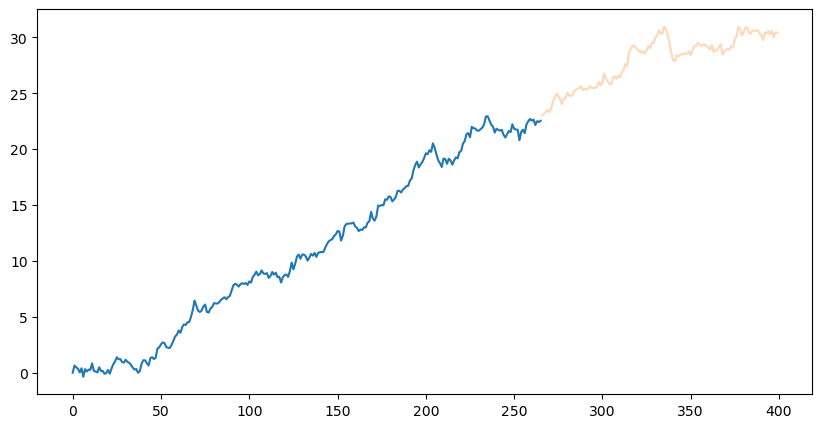

In [3]:
### Drift-Diffusion SDE

# Time discretization
Nt = 400 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
a = 0.3  # Drift rate
sigma = 0.8  # Noise level

# Initialize the time series
X = np.zeros(Nt)
X[0] = 0  # Starting point

np.random.seed(1)
# Generate the drift-diffusion time series
for t in range(1, Nt):
    dW = np.sqrt(dt) * np.random.normal()  # Wiener process (Brownian motion)
    X[t] = X[t-1] + a * dt + sigma * dW

# Store the generated time-series in a pandas DataFrame
df = pd.DataFrame({'Time': tspan, 'X': X})

# Split the data into training and testing sets
train = df['X'][0:int(Nt/3*2)]
test = df['X'][int(Nt/3*2):]

plt.figure(figsize=(10, 5))
plt.plot(train, alpha = 1)
plt.plot([np.nan]*len(train)+list(test), alpha = 0.3)



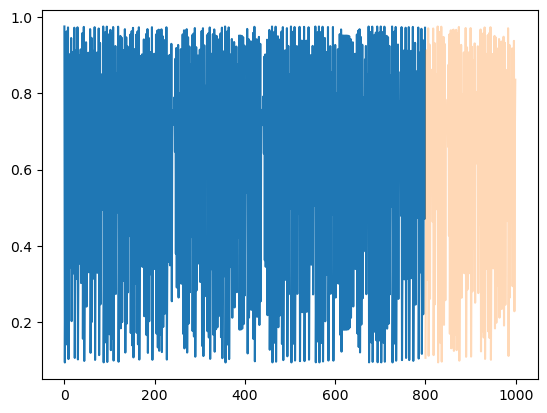

In [4]:
### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

# Parameters
r = 3.9  # Control parameter
x = 0.5  # Initial condition
Nt = 1000  # Number of iterations

time_series = []
for i in range(Nt):
    x = logistic_map(r, x)
    time_series.append(x)
    
df = pd.DataFrame({'X': time_series})
train = df['X'][0:int(Nt/5*4)]
test = df['X'][int(Nt/5*4):]

plt.plot(train, alpha = 1)
plt.plot([np.nan]*len(train)+list(test), alpha = 0.3)
plt.show()

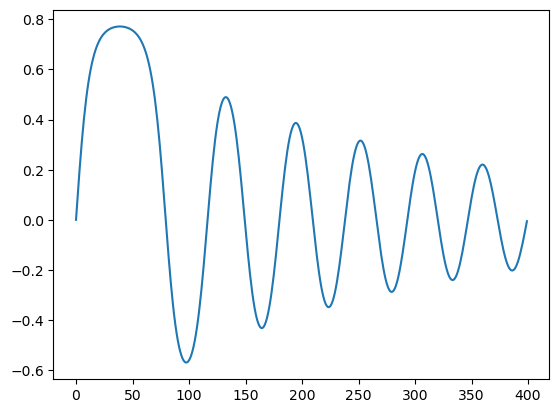

In [188]:
from scipy.integrate import odeint

### Non-linear pendulum
ds_name = 'Non-linear pendulum'

# Time discretization
Nt = 400
# Create grid of time steps
# tspan = np.linspace(0, 100, Nt)
tspan = np.linspace(0, 25, Nt)
# Damping parameter
lmbda = 0.1
# Define pendulum equation
w = 4

def dtheta(theta, t):
    return [theta[1], -np.sin(w * theta[0]) - lmbda * theta[1]]

# Specific initial condition
theta_ic = [0, 1.05]  
# theta_ic = [0.8, 0]  

# Solve the ODE
theta = odeint(dtheta, theta_ic, tspan)

# Extract the time-series
X = theta[:, 0]
Y = theta[:, 1]

# Store the generated time-series in a pandas DataFrame
df = pd.DataFrame({'Time': tspan, 'X': X})

train = df['X'][0:int(Nt/3*2)]
test = df['X'][int(Nt/3*2):]

plt.plot(df['X'])

### Running LLMTime and Keep Logits 

In [5]:
def llama_nll_fn(model, input_arr, target_arr, settings:SerializerSettings, transform, count_seps=True, temp=1):
    """ Returns the NLL/dimension (log base e) of the target array (continuous) according to the LM 
        conditioned on the input array. Applies relevant log determinant for transforms and
        converts from discrete NLL of the LLM to continuous by assuming uniform within the bins.
    inputs:
        input_arr: (n,) context array
        target_arr: (n,) ground truth array
    Returns: NLL/D
    """
    model, tokenizer = get_model_and_tokenizer(model)

    input_str = serialize_arr(vmap(transform)(input_arr), settings)
    target_str = serialize_arr(vmap(transform)(target_arr), settings)
    full_series = input_str + target_str
    
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
    batch = {k: v.cuda() for k, v in batch.items()}

    with torch.no_grad():
        out = model(**batch)

    good_tokens_str = list("0123456789" + settings.time_sep)
    good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
    bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
    out['logits'][:,:,bad_tokens] = -100
    # why not set to -inf?

    input_ids = batch['input_ids'][0][1:]
    logprobs = torch.nn.functional.log_softmax(out['logits'], dim=-1)[0][:-1]
    logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()

    tokens = tokenizer.batch_decode(
        input_ids,
        skip_special_tokens=False, 
        clean_up_tokenization_spaces=False
    )
    
    input_len = len(tokenizer([input_str], return_tensors="pt",)['input_ids'][0])
    input_len = input_len - 2 # remove the BOS token

    logprobs = logprobs[input_len:]
    tokens = tokens[input_len:]
    BPD = -logprobs.sum()/len(target_arr)

    #print("BPD unadjusted:", -logprobs.sum()/len(target_arr), "BPD adjusted:", BPD)
    # log p(x) = log p(token) - log bin_width = log p(token) + prec * log base
    transformed_nll = BPD - settings.prec*np.log(settings.base)
    avg_logdet_dydx = np.log(vmap(grad(transform))(target_arr)).mean()
    return transformed_nll-avg_logdet_dydx


In [6]:
### Temperature tuning
num_samples = 1
# temp_list = [0.1, 0.5, 1, 1.5]
# temp_list = [0.5, 1, 1.5]
temp_list = [1.3]
temp_list = [1]

### Llama 70-B takes 30 minutes to run

for model in model_names: # GPT-4 takes a about a minute to run
    hypers = list(grid_iter(model_hypers[model]))
    for temp in temp_list:
        hypers[0]['temp'] = temp
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'llama-7b', 'alpha': 0.99, 'beta': 0.3, 'temp': 1, 'basic': False, 'settings': SerializerSettings(base=10, prec=2, signed=True, fixed_length=False, max_val=10000000.0, time_sep=',', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf
train: ... [0.77840004 0.67272434 0.85864858 0.47334766 0.97222965 0.10529673
 0.36741637 0.90644417 0.33073223 0.86325885 0.46036774 0.96887421
 0.11761221 0.40474036 0.93960985 0.22129841 0.67206916 0.8595296
 0.47088001 0.9716929 ]
test: ... 800    0.107273
801    0.373484
802    0.912576
803    0.311147
804    0.835904
805    0.534956
806    0.970234
807    0.112630
808    0.389785
809    0.927625
810    0.261833
811    0.753779
812    0.723825
813    0.779619
814    0.670072
815    0.862195
816    0.463378
817    0.969770
818    0.114335
819    0.394923
Name: X, dtype: float64


  0%|          | 0/1 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

### In-context loss functions

In [7]:
import torch
torch.cuda.empty_cache()
from models.llama import get_model_and_tokenizer, get_tokenizer

model, tokenizer = get_model_and_tokenizer('13b')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
from data.serialize import serialize_arr
X = np.append(train.values, test.values) 
settings = llama_hypers['settings']
full_series = serialize_arr((X-X.min())/(X.max()-X.min())+0.1, settings)

In [19]:
full_series

'110,10,37,98,49,108,15,53,109,11,40,101,38,99,46,106,22,70,102,36,96,52,109,11,41,102,34,94,58,109,10,40,101,39,100,41,103,33,92,63,108,17,57,109,10,38,99,44,105,26,80,89,71,102,36,97,51,109,12,46,106,22,70,102,34,94,58,109,10,39,100,40,102,36,97,51,109,12,44,105,27,81,87,76,95,55,109,10,37,98,49,108,15,54,109,10,37,98,47,107,18,61,109,13,48,108,17,58,109,10,39,100,43,104,30,87,76,96,54,109,10,38,98,46,107,20,65,106,22,70,102,34,93,60,109,12,46,106,21,69,104,30,88,74,98,47,107,18,62,108,15,52,109,11,42,103,33,92,64,107,18,62,108,15,53,109,10,40,101,39,101,40,101,38,99,45,106,23,74,98,47,107,18,60,109,12,46,106,22,70,102,36,96,53,109,10,39,100,40,101,37,98,47,107,18,61,108,14,50,109,13,47,107,18,60,109,13,46,107,20,66,105,24,75,96,53,109,10,40,101,39,101,40,101,38,99,43,104,28,83,84,82,85,80,88,72,100,42,103,32,90,68,104,29,85,80,90,70,103,33,92,64,107,18,61,108,14,49,108,14,51,109,12,46,106,21,69,104,30,88,74,98,47,107,19,63,107,17,59,109,11,42,103,31,89,71,101,39,100,41,103,33,93,62,

In [10]:
batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
batch = {k: v.cuda() for k, v in batch.items()}
input_ids = batch['input_ids'][0][1:]

In [11]:
with torch.no_grad():
    out = model(**batch)
    

with open(f"plot_output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl", 'wb') as f:
            pickle.dump(out['logits'], f)

In [20]:
# ### hand-serialized brownian motion 7b
# with open('plot_output/2023-11-07_00-02-33.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ### hand-serialized brownian motion 13b
# with open('plot_output/2023-11-07_03-05-43.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
### hand-serialized Logistic map 13b r=3.9, prec=3
# with open('plot_output/2023-11-14_03-28-45.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
### hand-serialized Logistic map 13b r=3.9, prec=2
with open('plot_output/2023-11-20_06-16-07.pkl', 'rb') as f:
    logit_mat = pickle.load(f)
    
# # ### hand-serialized Logistic map 13b r=3.89
# with open('plot_output/2023-11-14_03-33-34.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# # ### hand-serialized Logistic map 13b r=3.7
# with open('plot_output/2023-11-14_03-38-10.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# # ### hand-serialized Logistic map 13b r=3.6
# with open('plot_output/2023-11-14_03-41-23.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ### hand-serialized Logistic map 13b r=3.58
# with open('plot_output/2023-11-14_03-45-39.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# # ### hand-serialized Logistic map 13b r=3.5
# with open('plot_output/2023-11-14_03-49-47.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

### hand-serialized Non-linear pendulum 13b, T=25
# with open('plot_output/2023-11-14_03-01-05.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
### hand-serialized Non-linear pendulum 13b, T=100
# with open('plot_output/2023-11-14_03-15-06.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

In [13]:
good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
logit_mat[:,:,bad_tokens] = -np.inf


In [21]:
logit_mat.shape

torch.Size([1, 3268, 32000])

In [14]:
logprobs = torch.nn.functional.log_softmax(logit_mat, dim=-1)[0][:-1]
# logprob of the full trajectory
logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()
NLL = -logprobs

In [22]:
NLL.shape

(3267,)

In [43]:
char_array = np.array(list(full_series))
comma_locations = np.where(char_array == ',')[0][:-1]

NLL_digit = -logprobs[comma_locations+1-2]

[]

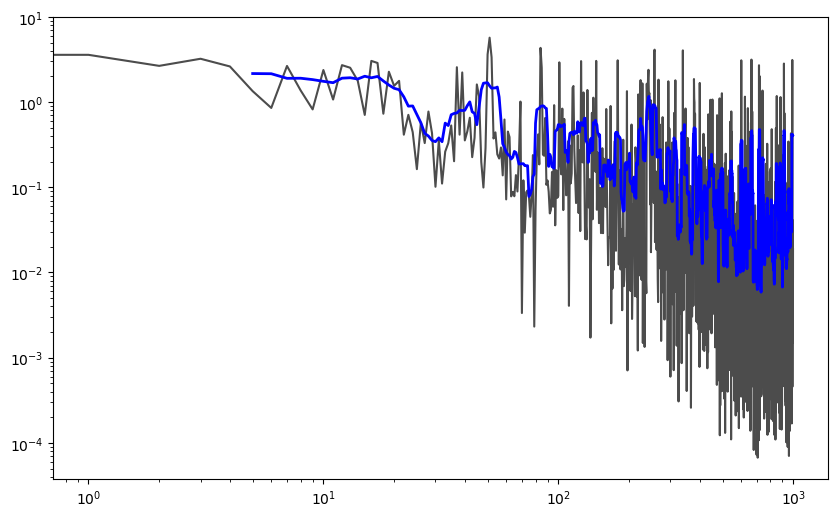

In [48]:
window_size = 10


top_hat_kernel = np.ones(window_size) / window_size
averaged_loss = np.convolve(NLL_digit, top_hat_kernel, mode='valid')
plt.figure(figsize=(10, 6))
plt.plot(NLL_digit, label="Original Loss", alpha=0.7, c = 'black')
plt.plot(np.arange(window_size//2, len(NLL_digit) - window_size//2 + 1), averaged_loss, label="Averaged Loss", linewidth=2, c = 'blue')
# plt.xlabel("Context length")
# plt.ylabel("Averaged NLL")
plt.loglog()

In [17]:
NLL_digit.shape

(999,)